In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [ ]:
train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

In [ ]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


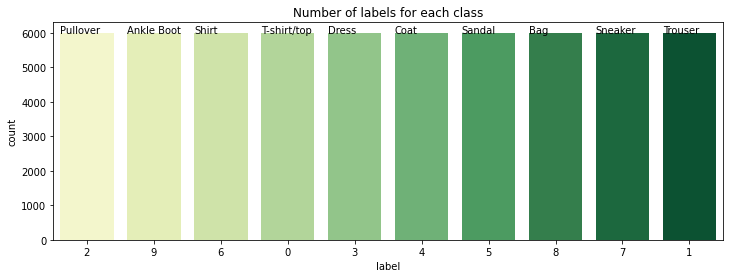

In [ ]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index, palette='YlGn')
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()

plot_label_per_class(train_data)

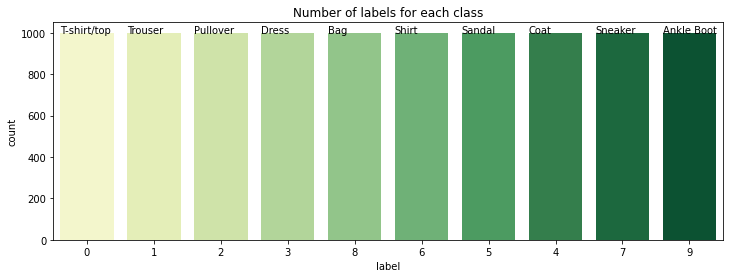

In [ ]:
plot_label_per_class(test_data)

In [ ]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(28,28)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


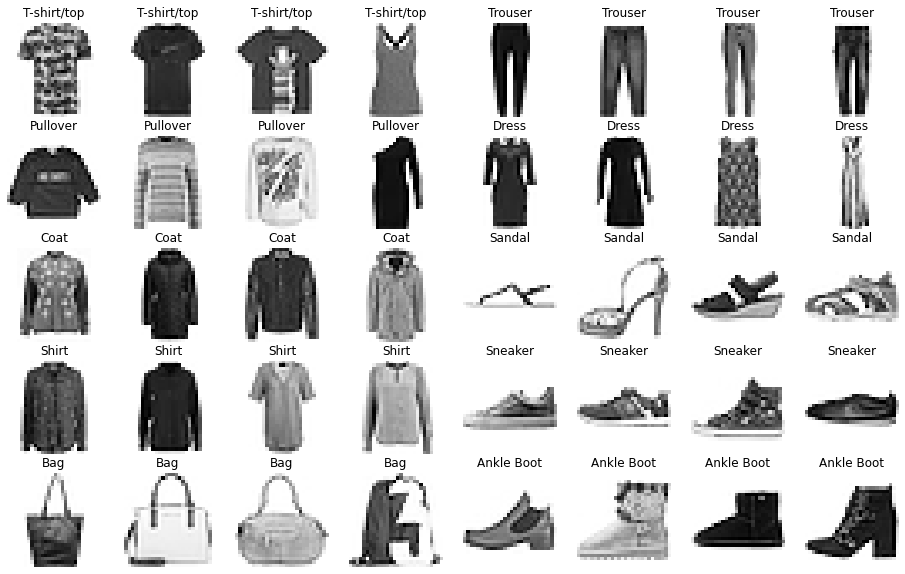

In [ ]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Greys"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()

plot_sample_images(train_sample_images,train_sample_labels, "Greys")

Total number of sample images to plot:  40


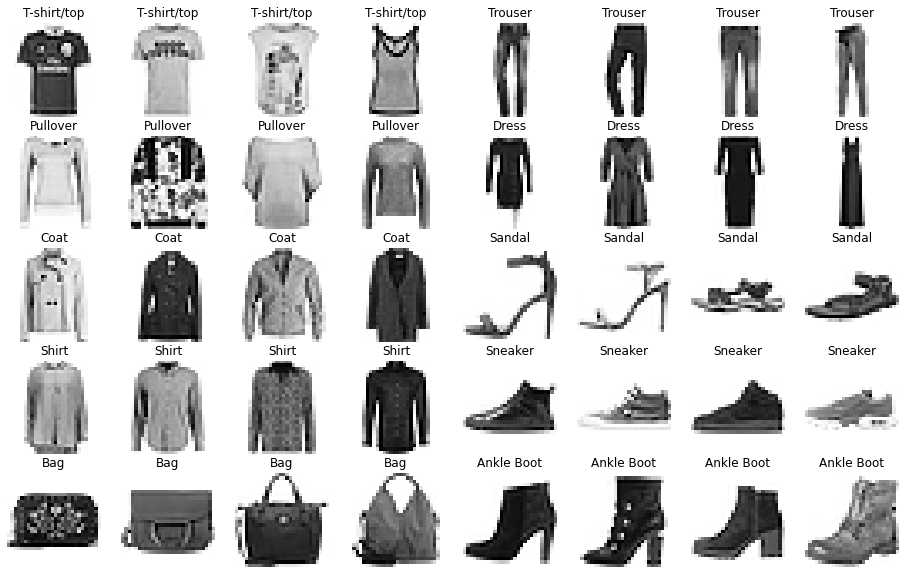

In [ ]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels,"Greys")

In [ ]:
# data preprocessing
def data_preprocessing(raw):
    out_y = keras.utils.np_utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from keras.utils import np_utils

# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
print("training set size",x_train.shape[0], x_train.shape[1:4])
print("validation set size",x_val.shape[0], x_val.shape[1:4])
print("test set size",X_test.shape[0]," columns:", X_test.shape[1:4])

training set size 48000 (28, 28, 1)
validation set size 12000 (28, 28, 1)
test set size 10000  columns: (28, 28, 1)


# **ResNet 18**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from torchvision.datasets import FashionMNIST
from torchvision.models import resnet18

# Используем ResNet18 как базовую модель
resnet = resnet18(pretrained=True)  # Загружаем предобученные веса
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # Настраиваем для 10 классов

# Переносим модель на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [ ]:
# Трансформация данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер изображения для ResNet
    transforms.Grayscale(num_output_channels=3),  # Преобразуем в трехканальное изображение
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация для трех каналов
])


# Загрузка данных
train_dataset = FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.33MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.18MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
from torch.utils.data import random_split

In [ ]:
train_size = int(0.8 * len(train_dataset))  # 80% для обучения
val_size = len(train_dataset) - train_size  # Оставшиеся 20% для валидации
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
def compute_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Обучение
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Валидация
    val_accuracy = compute_accuracy(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100*correct/total:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Loss: 0.3256, Train Accuracy: 88.20%, Validation Accuracy: 91.05%
Epoch [2/10], Loss: 0.2189, Train Accuracy: 91.95%, Validation Accuracy: 92.63%
Epoch [3/10], Loss: 0.1850, Train Accuracy: 93.16%, Validation Accuracy: 92.86%
Epoch [4/10], Loss: 0.1577, Train Accuracy: 94.31%, Validation Accuracy: 93.01%
Epoch [5/10], Loss: 0.1322, Train Accuracy: 95.19%, Validation Accuracy: 93.72%
Epoch [6/10], Loss: 0.1071, Train Accuracy: 96.10%, Validation Accuracy: 93.67%
Epoch [7/10], Loss: 0.0826, Train Accuracy: 96.97%, Validation Accuracy: 93.72%
Epoch [8/10], Loss: 0.0651, Train Accuracy: 97.64%, Validation Accuracy: 93.37%
Epoch [9/10], Loss: 0.0492, Train Accuracy: 98.19%, Validation Accuracy: 93.72%
Epoch [10/10], Loss: 0.0375, Train Accuracy: 98.69%, Validation Accuracy: 93.92%


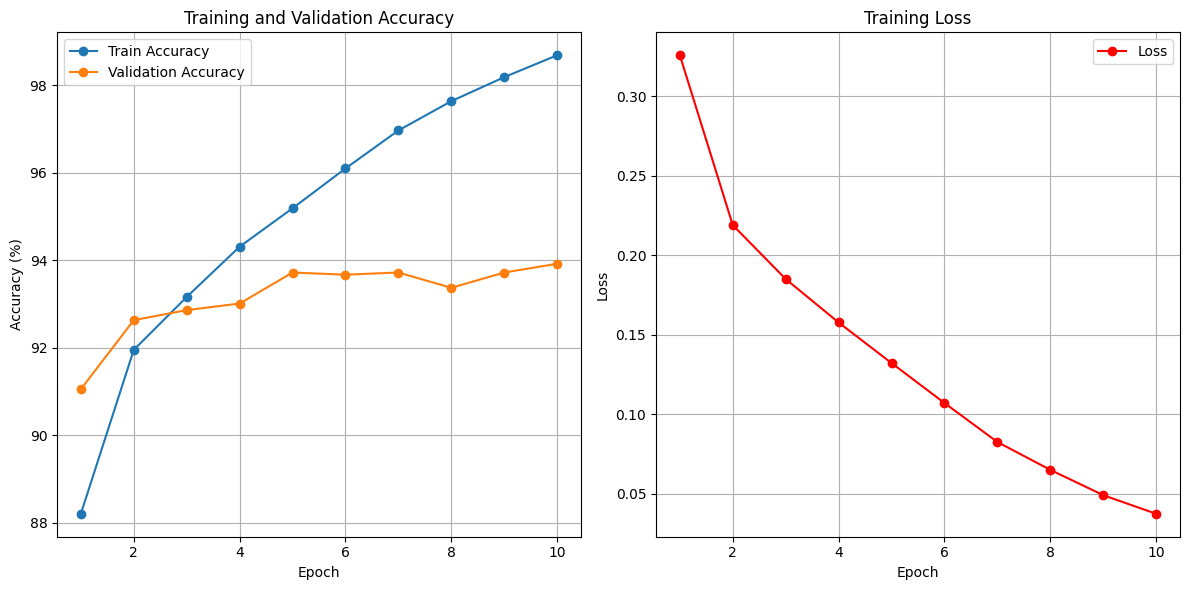

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 11))
train_accuracies = [88.20, 91.95, 93.16, 94.31, 95.19, 96.10, 96.97, 97.64, 98.19, 98.69]
val_accuracies = [91.05, 92.63, 92.86, 93.01, 93.72, 93.67, 93.72, 93.37, 93.72, 93.92]
losses = [0.3256, 0.2189, 0.1850, 0.1577, 0.1322, 0.1071, 0.0826, 0.0651, 0.0492, 0.0375]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, losses, label="Loss", marker='o', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Hyperparameter tuning

In [ ]:
from torchvision.models import resnet18

class AdvancedResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedResNet, self).__init__()
        # Load pretrained ResNet18 and fine-tune
        self.resnet = resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = True  # Fine-tune all layers

        # Replace FC with a custom head
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
advanced_resnet = AdvancedResNet(num_classes=10).to(device)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(advanced_resnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [ ]:
num_epochs = 15
best_val_accuracy = 0

for epoch in range(num_epochs):
    advanced_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = advanced_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total

    # Validation
    advanced_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = advanced_resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct / total
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(advanced_resnet.state_dict(), 'best_advanced_resnet.pth')

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


Epoch [1/15], Loss: 0.3693, Train Accuracy: 87.34%, Validation Accuracy: 91.53%
Epoch [2/15], Loss: 0.2435, Train Accuracy: 91.52%, Validation Accuracy: 90.36%
Epoch [3/15], Loss: 0.1992, Train Accuracy: 92.99%, Validation Accuracy: 91.81%
Epoch [4/15], Loss: 0.1691, Train Accuracy: 94.19%, Validation Accuracy: 93.82%
Epoch [5/15], Loss: 0.1335, Train Accuracy: 95.40%, Validation Accuracy: 93.88%
Epoch [6/15], Loss: 0.0938, Train Accuracy: 96.72%, Validation Accuracy: 94.67%
Epoch [7/15], Loss: 0.0573, Train Accuracy: 98.06%, Validation Accuracy: 94.78%
Epoch [8/15], Loss: 0.0264, Train Accuracy: 99.21%, Validation Accuracy: 94.53%
Epoch [9/15], Loss: 0.0088, Train Accuracy: 99.77%, Validation Accuracy: 94.97%
Epoch [10/15], Loss: 0.0037, Train Accuracy: 99.93%, Validation Accuracy: 94.96%
Epoch [11/15], Loss: 0.0030, Train Accuracy: 99.95%, Validation Accuracy: 94.97%
Epoch [12/15], Loss: 0.0027, Train Accuracy: 99.96%, Validation Accuracy: 94.95%
Epoch [13/15], Loss: 0.0044, Train Ac

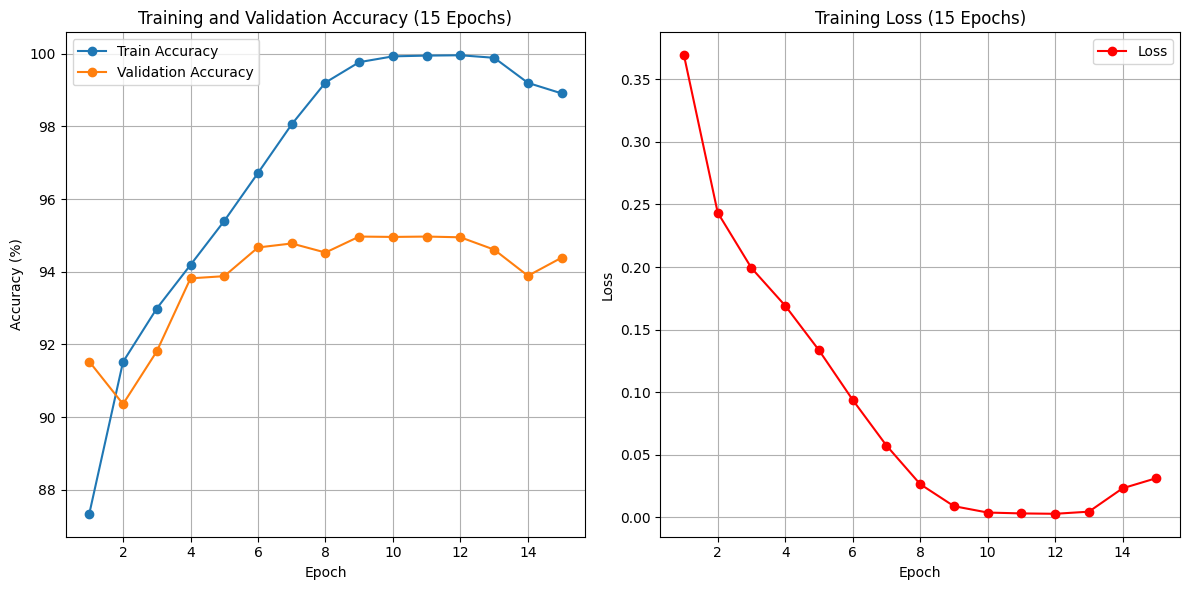

In [ ]:
# Updated data for plotting
epochs_15 = list(range(1, 16))
train_accuracies_15 = [
    87.34, 91.52, 92.99, 94.19, 95.40, 96.72, 98.06, 99.21, 99.77, 99.93,
    99.95, 99.96, 99.89, 99.20, 98.91
]
val_accuracies_15 = [
    91.53, 90.36, 91.81, 93.82, 93.88, 94.67, 94.78, 94.53, 94.97, 94.96,
    94.97, 94.95, 94.61, 93.89, 94.39
]
losses_15 = [
    0.3693, 0.2435, 0.1992, 0.1691, 0.1335, 0.0938, 0.0573, 0.0264, 0.0088,
    0.0037, 0.0030, 0.0027, 0.0044, 0.0231, 0.0312
]

# Plot accuracy for 15 epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_15, train_accuracies_15, label="Train Accuracy", marker='o')
plt.plot(epochs_15, val_accuracies_15, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy (15 Epochs)")
plt.legend()
plt.grid(True)

# Plot loss for 15 epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_15, losses_15, label="Loss", marker='o', color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (15 Epochs)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch.nn.functional as F

# Load the best model
advanced_resnet.load_state_dict(torch.load('best_advanced_resnet.pth'))
advanced_resnet.eval()

all_labels = []
all_predictions = []
test_loss = 0.0

# Evaluate the model
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is your test DataLoader
        images, labels = images.to(device), labels.to(device)
        outputs = advanced_resnet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

<ipython-input-20-e25728fed65d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  advanced_resnet.load_state_dict(torch.load('best_advanced_resnet.pth'))


In [ ]:
accuracy = accuracy_score(all_labels, all_predictions) * 100
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")

Test Loss: 0.2472
Test Accuracy: 94.35%
Precision: 94.32%
Recall: 94.35%
F1-Score: 94.32%


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1000
           1       1.00      0.99      0.99      1000
           2       0.91      0.92      0.92      1000
           3       0.93      0.95      0.94      1000
           4       0.92      0.92      0.92      1000
           5       0.99      0.99      0.99      1000
           6       0.86      0.80      0.83      1000
           7       0.97      0.98      0.98      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2472, Test Accuracy: 94.35%


# **CNN**

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [ ]:
# Model
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Dense(128, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Dense(10, activation='softmax'))

2022-11-12 06:18:20.857078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 06:18:20.979638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 06:18:20.980561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 06:18:20.982590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        2

In [ ]:
train_model = cnn.fit(x_train, y_train,
                  batch_size=256,
                  epochs=100,
                  validation_data=(x_val, y_val))

2022-11-12 06:18:24.473667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-12 06:18:26.509100: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


188/188 [==============================] - 12s 21ms/step - loss: 0.5758 - accuracy: 0.8044 - val_loss: 2.5222 - val_accuracy: 0.1907
Epoch 2/100
188/188 [==============================] - 4s 19ms/step - loss: 0.3470 - accuracy: 0.8779 - val_loss: 1.2543 - val_accuracy: 0.6043
Epoch 3/100
188/188 [==============================] - 4s 19ms/step - loss: 0.2821 - accuracy: 0.8995 - val_loss: 0.3032 - val_accuracy: 0.8937
Epoch 4/100
188/188 [==============================] - 4s 19ms/step - loss: 0.2387 - accuracy: 0.9145 - val_loss: 0.2614 - val_accuracy: 0.9060
Epoch 5/100
188/188 [==============================] - 4s 19ms/step - loss: 0.2046 - accuracy: 0.9266 - val_loss: 0.2295 - val_accuracy: 0.9186
Epoch 6/100
188/188 [==============================] - 4s 19ms/step - loss: 0.1792 - accuracy: 0.9360 - val_loss: 0.2228 - val_accuracy: 0.9251
Epoch 7/100
188/188 [==============================] - 4s 19ms/step - loss: 0.1602 - accuracy: 0.9424 - val_loss: 0.2549 - val_accuracy: 0.9134
Epo

In [ ]:
score = cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3849482834339142
Test accuracy: 0.9229999780654907


# **Hyperparameter tuning**

### CNN with 4 convolutional layers

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn1.add(BatchNormalization())

cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.25))

cnn1.add(Flatten())

cnn1.add(Dense(512, activation='relu'))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.5))

cnn1.add(Dense(128, activation='relu'))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.5))

cnn1.add(Dense(10, activation='softmax'))

In [ ]:
cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)       

In [ ]:
history = cnn1.fit(x_train, y_train,
          batch_size=256,
          epochs=100,
          validation_data=(x_val, y_val))

Epoch 1/100
188/188 [==============================] - 4s 15ms/step - loss: 0.7634 - accuracy: 0.7356 - val_loss: 2.7514 - val_accuracy: 0.1113
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 0.4460 - accuracy: 0.8390 - val_loss: 1.8789 - val_accuracy: 0.4850
Epoch 3/100
188/188 [==============================] - 2s 13ms/step - loss: 0.3791 - accuracy: 0.8646 - val_loss: 0.5504 - val_accuracy: 0.8075
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 0.3372 - accuracy: 0.8812 - val_loss: 0.2850 - val_accuracy: 0.8995
Epoch 5/100
188/188 [==============================] - 2s 13ms/step - loss: 0.3117 - accuracy: 0.8904 - val_loss: 0.3002 - val_accuracy: 0.8866
Epoch 6/100
188/188 [==============================] - 2s 13ms/step - loss: 0.2900 - accuracy: 0.8973 - val_loss: 0.2377 - val_accuracy: 0.9143
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.2739 - accuracy: 0.9035 - val_loss: 0.2869 - val_accuracy:

In [ ]:
score = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23831906914710999
Test accuracy: 0.9437000155448914


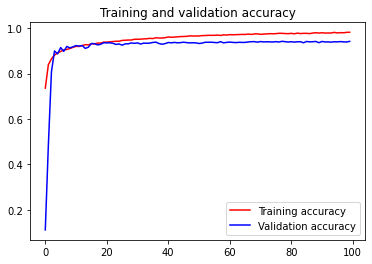

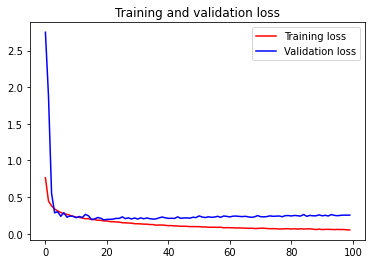

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predictions for the test data
predicted_classes = (cnn1.predict(X_test) > 0.5).astype("int32")

# Indices to be plotted
y_true = y_test
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.92      0.89      0.91      1000
     Class 1       1.00      1.00      1.00      1000
     Class 2       0.94      0.89      0.91      1000
     Class 3       0.95      0.96      0.95      1000
     Class 4       0.92      0.92      0.92      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.82      0.85      0.83      1000
     Class 7       0.97      0.97      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.97      0.98      0.97      1000

   micro avg       0.95      0.94      0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000



# COMPARISON ANALYSIS

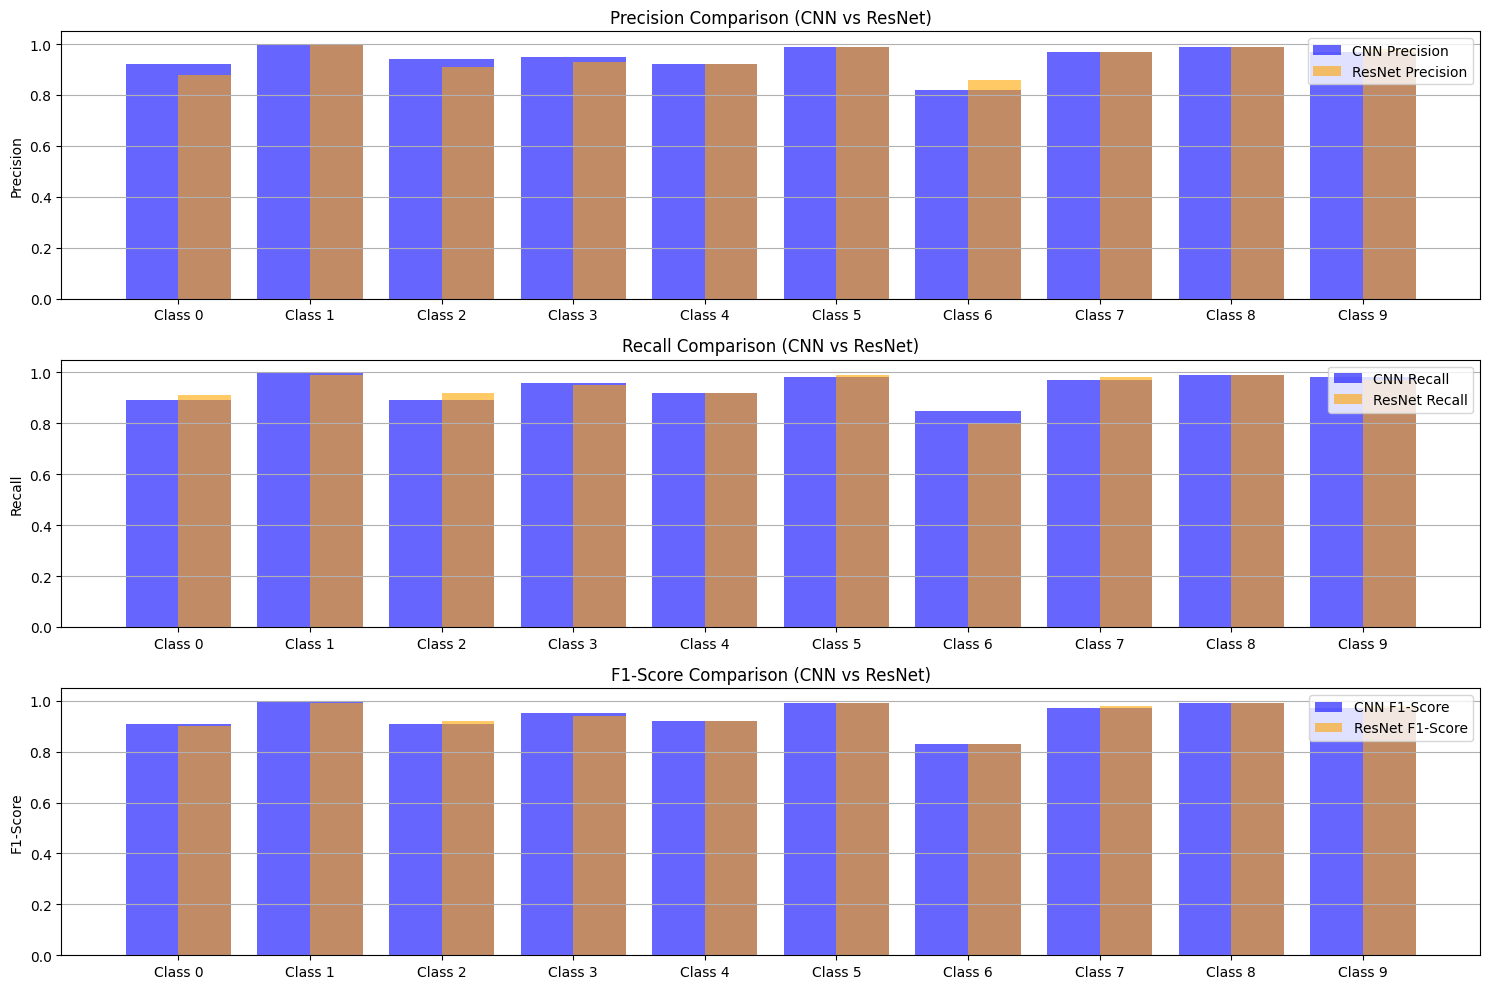

In [ ]:
# Data for CNN and ResNet metrics comparison
classes = [f"Class {i}" for i in range(10)]
cnn_precision = [0.92, 1.00, 0.94, 0.95, 0.92, 0.99, 0.82, 0.97, 0.99, 0.97]
cnn_recall = [0.89, 1.00, 0.89, 0.96, 0.92, 0.98, 0.85, 0.97, 0.99, 0.98]
cnn_f1 = [0.91, 1.00, 0.91, 0.95, 0.92, 0.99, 0.83, 0.97, 0.99, 0.97]

resnet_precision = [0.88, 1.00, 0.91, 0.93, 0.92, 0.99, 0.86, 0.97, 0.99, 0.98]
resnet_recall = [0.91, 0.99, 0.92, 0.95, 0.92, 0.99, 0.80, 0.98, 0.99, 0.97]
resnet_f1 = [0.90, 0.99, 0.92, 0.94, 0.92, 0.99, 0.83, 0.98, 0.99, 0.98]

# Plot comparison of precision, recall, and F1-score
plt.figure(figsize=(15, 10))

# Precision Comparison
plt.subplot(3, 1, 1)
plt.bar(classes, cnn_precision, alpha=0.6, label="CNN Precision", color='blue')
plt.bar(classes, resnet_precision, alpha=0.6, label="ResNet Precision", color='orange', width=0.4, align='edge')
plt.ylabel("Precision")
plt.title("Precision Comparison (CNN vs ResNet)")
plt.legend()
plt.grid(axis='y')

# Recall Comparison
plt.subplot(3, 1, 2)
plt.bar(classes, cnn_recall, alpha=0.6, label="CNN Recall", color='blue')
plt.bar(classes, resnet_recall, alpha=0.6, label="ResNet Recall", color='orange', width=0.4, align='edge')
plt.ylabel("Recall")
plt.title("Recall Comparison (CNN vs ResNet)")
plt.legend()
plt.grid(axis='y')

# F1-Score Comparison
plt.subplot(3, 1, 3)
plt.bar(classes, cnn_f1, alpha=0.6, label="CNN F1-Score", color='blue')
plt.bar(classes, resnet_f1, alpha=0.6, label="ResNet F1-Score", color='orange', width=0.4, align='edge')
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison (CNN vs ResNet)")
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()


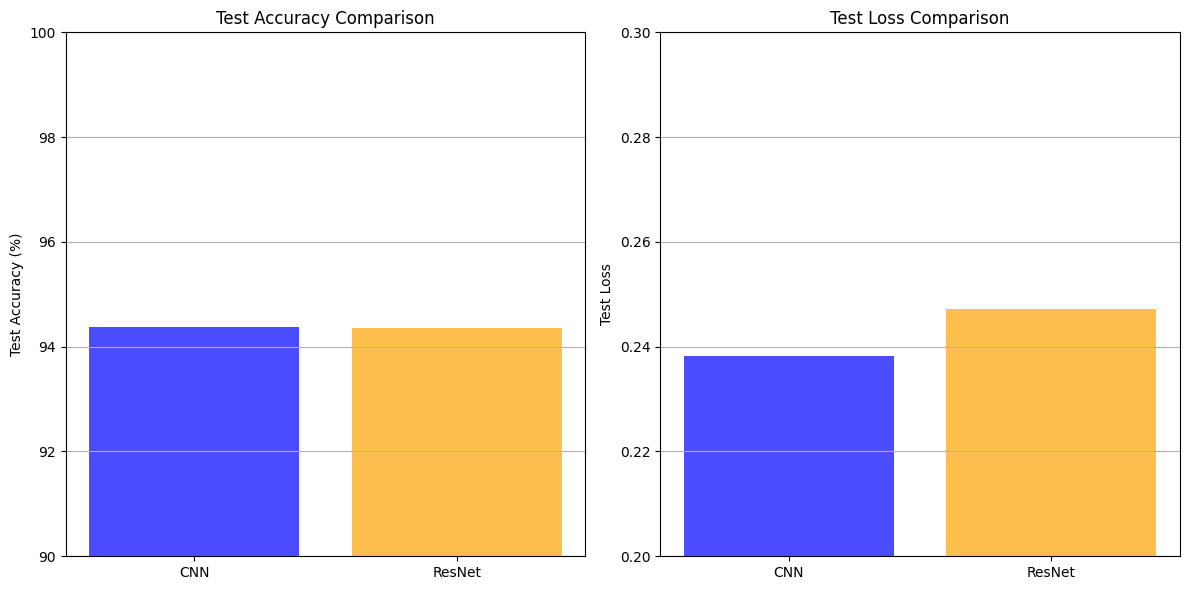

In [ ]:
# Test accuracy and loss data for comparison
models = ["CNN", "ResNet"]
test_accuracy = [94.37, 94.35]  # In percentage
test_loss = [0.2383, 0.2472]  # Loss values

# Plot comparison of Test Accuracy and Loss
plt.figure(figsize=(12, 6))

# Test Accuracy Comparison
plt.subplot(1, 2, 1)
plt.bar(models, test_accuracy, color=['blue', 'orange'], alpha=0.7)
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison")
plt.ylim(90, 100)
plt.grid(axis='y')

# Test Loss Comparison
plt.subplot(1, 2, 2)
plt.bar(models, test_loss, color=['blue', 'orange'], alpha=0.7)
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison")
plt.ylim(0.2, 0.3)
plt.grid(axis='y')

plt.tight_layout()
plt.show()
